In [1]:
%pip install -q tensorflow-gpu gym keras keras-rl2 pyvirtualdisplay pyglet


You should consider upgrading via the '/media/programming/projects/machineLearning/ML/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from gym import Env
from gym.spaces import Discrete, Box
import numpy as np
import random
import matplotlib.pyplot as plt
import pyvirtualdisplay
import PIL.Image
from gym.wrappers import RecordVideo


In [3]:
display = pyvirtualdisplay.Display(visible=0, size=(28, 28)).start()

In [54]:
class SnakeWorldEnv(Env):
    metadata = {'render_modes': ['human']}

    def __init__(self):
        world_size = (28, 28)
        # Actions we can take, down, stay, up
        self.action_space = Discrete(4)
        self.observation_space = Box(low=np.array([0]), high=np.array([2]), dtype=np.float32)

        # World Space
        self.state = np.zeros(shape=world_size).astype(dtype='float32')

        self.snake_length = 3
        self.snake_head_position = (0, 0)
        self.apple_position = (0, 0)
        self.last_time_grown = 0

    def step(self, action):

        done = False
        reward = 1

        # Update params.
        # Apply action
        # Remove head from previous.
        self.state[int(self.snake_head_position[0]), int(self.snake_head_position[1])] = 0
        # Move the last sequence to the next position.
        if action == 0:
            self.snake_head_position += np.array([1, 0])
        if action == 1:
            self.snake_head_position += np.array([-1, 0])
        if action == 2:
            self.snake_head_position += np.array([0, 1])
        if action == 3:
            self.snake_head_position += np.array([0, -1])

        if self.snake_head_position[0] >= 28 or self.snake_head_position[0] < 0:
            done = True
 #           reward = 0
        if self.snake_head_position[1] >= 28 or self.snake_head_position[1] < 0:
            done = True
#            reward = -200
        
        if not done:
            # Update new position
            self.state[int(self.snake_head_position[0]), int(self.snake_head_position[1])] = 1

            #
            self.last_time_grown += 1

            apple_consumed = False
            # If snake overlap.

            if self.state[self.apple_position[0], self.apple_position[1]] == 1:
                apple_consumed = True
            # Calculate reward
            # If closer. small reward, get apple. big reward.
            if apple_consumed:
                reward = 500 + self.snake_length * 2
                self.snake_length += 1
                self.last_time_grown = 0
                
                # Update apple position
                self.state[self.apple_position[0], self.apple_position[1]] = 0
                self.apple_position = np.random.randint(size=(2,), low=0, high=28)
                self.state[self.apple_position[0], self.apple_position[1]] = 2
            else:
                # Check if timeout.
                if self.last_time_grown >= 200 - self.snake_length:
                    done = True
                #    reward = -60
                else:
                    done = False

        # Set placeholder for info
        info = {}

        # Return step information
        return np.squeeze(np.array(self.state.flatten(), dtype=np.float32)), reward, done, info

    def render(self, mode=""):
        fig = plt.figure("")
        plt.imshow(self.state)
        plt.scatter(self.apple_position[1], self.apple_position[0])
        plt.close()
        fig.canvas.draw()
        data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))

        return data

    def reset(self):
        self.snake_length = 3
        self.snake_head_position = np.asarray(self.state.shape, dtype=int) / 2
        self.snake_last_position = np.asarray(self.snake_head_position - (0, 3))

        self.state = np.zeros(shape=self.state.shape).astype(dtype='float32')

#        for x in range(0, self.snake_length):
        self.state[int(self.snake_head_position[0]), int(self.snake_head_position[1])] = 1

        self.apple_position = np.random.randint(size=(2,), low=0, high=28)
        self.state[self.apple_position[0], self.apple_position[1]] = 2
        self.last_time_grown = 0

        result = np.squeeze(np.array(self.state.flatten(), dtype=np.float32))
        return result.reshape(28*28)


In [55]:
env = SnakeWorldEnv()

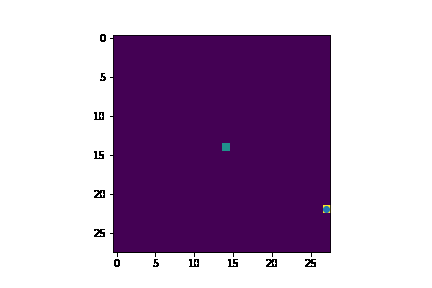

In [56]:
env.reset()
PIL.Image.fromarray(env.render())


In [57]:
env = RecordVideo(env, video_folder='video', step_trigger=lambda e: True)
env.start_video_recorder()


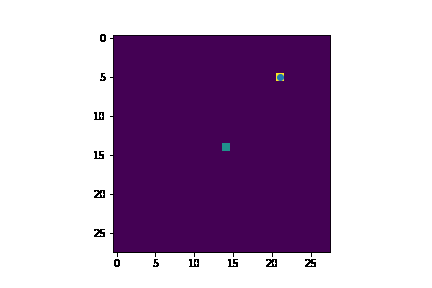

In [58]:
env.reset()
PIL.Image.fromarray(env.render())

In [59]:
observation = env.reset()
print(observation.shape, observation.dtype)

(784,) float32


In [60]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow import keras

In [61]:
states = env.state.shape
actions = env.action_space.n

In [62]:
actions


4

In [63]:
states

(28, 28)

In [64]:
def build_model(states, actions):
    model = Sequential(name="")    
    model.add(keras.layers.Input((1, 784)))
    model.add(keras.layers.Flatten())
    model.add(Dense(units=48, activation='relu'))
    model.add(Dense(units=24, activation='relu'))

    model.add(Dense(units=actions, activation='relu'))
    return model


In [65]:
del model 
model = build_model(observation.shape, actions)
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 784)               0         
                                                                 
 dense_12 (Dense)            (None, 48)                37680     
                                                                 
 dense_13 (Dense)            (None, 24)                1176      
                                                                 
 dense_14 (Dense)            (None, 4)                 100       
                                                                 
Total params: 38,956
Trainable params: 38,956
Non-trainable params: 0
_________________________________________________________________


In [66]:

#env = tf_py_environment.TFPyEnvironment(env)


In [67]:
from rl.agents import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory

In [68]:
def build_agent(model, actions):
    policy = BoltzmannQPolicy()
    memory = SequentialMemory(limit=50000, window_length=1)
    dqn = DQNAgent(model=model, memory=memory, policy=policy, 
                  nb_actions=actions, nb_steps_warmup=10, target_model_update=1e-2)
    return dqn

In [69]:
dqn = build_agent(model, actions)

dqn.compile(Adam(learning_rate=1e-3), metrics=['mae'])
dqn.fit(env, nb_steps=100000, visualize=False, verbose=1)

Training for 100000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 59s 6ms/step - reward: 1.1010
87 episodes - episode_reward: 125.299 [15.000, 857.000] - loss: 55.976 - mae: 77.000 - mean_q: 112.338

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 58s 6ms/step - reward: 1.2525
74 episodes - episode_reward: 169.459 [14.000, 702.000] - loss: 229.317 - mae: 199.627 - mean_q: 290.090

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 57s 6ms/step - reward: 1.3030
83 episodes - episode_reward: 156.964 [14.000, 646.000] - loss: 1488.969 - mae: 468.078 - mean_q: 664.261

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 58s 6ms/step - reward: 1.5052
66 episodes - episode_reward: 229.455 [14.000, 1363.000] - loss: 6249.343 - mae: 1004.418 - mean_q: 1392.799

Interval 5 (40000 steps performed)
10000/10000 [==============================] - 58s 6ms/step - re

In [71]:

scores = dqn.test(env, nb_episodes=100, visualize=False)
print(np.mean(scores.history['episode_reward']))

env.close_video_recorder()

Testing for 100 episodes ...
Episode 1: reward: 197.000, steps: 197
Episode 2: reward: 197.000, steps: 197
Episode 3: reward: 197.000, steps: 197
Episode 4: reward: 197.000, steps: 197
Episode 5: reward: 197.000, steps: 197
Episode 6: reward: 197.000, steps: 197
Episode 7: reward: 702.000, steps: 197
Episode 8: reward: 25.000, steps: 25
Episode 9: reward: 22.000, steps: 22
Episode 10: reward: 197.000, steps: 197
Episode 11: reward: 197.000, steps: 197
Episode 12: reward: 197.000, steps: 197
Episode 13: reward: 197.000, steps: 197
Episode 14: reward: 197.000, steps: 197
Episode 15: reward: 197.000, steps: 197
Episode 16: reward: 25.000, steps: 25
Episode 17: reward: 197.000, steps: 197
Episode 18: reward: 197.000, steps: 197
Episode 19: reward: 15.000, steps: 15
Episode 20: reward: 197.000, steps: 197
Episode 21: reward: 197.000, steps: 197
Episode 22: reward: 197.000, steps: 197
Episode 23: reward: 25.000, steps: 25
Episode 24: reward: 197.000, steps: 197
Episode 25: reward: 197.000, s